In [2]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy.io
import pandas as pd

def to_df(mat_db):
    """Returns one pd.DataFrame per cycle type"""

    # Features common for every cycle
    cycles_cols = ['type', 'ambient_temperature', 'time']

    # Features monitored during the cycle
    features_cols = {
        'charge': ['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                   'Current_charge', 'Voltage_charge', 'Time'],
        'discharge': ['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                      'Current_charge', 'Voltage_charge', 'Time', 'Capacity'],
        'impedance': ['Sense_current', 'Battery_current', 'Current_ratio',
                      'Battery_impedance', 'Rectified_impedance', 'Re', 'Rct']
    }

    # Define one pd.DataFrame per cycle type
    df = {key: pd.DataFrame() for key in features_cols.keys()}

    # Get every cycle
    cycles = [[row.flat[0] for row in line] for line in mat_db[0][0][0][0]]

    # Get measures for every cycle
    for cycle_id, cycle_data in enumerate(cycles):
        tmp = pd.DataFrame()

        # Data series for every cycle
        features_x_cycle = cycle_data[-1]

        # Get features for the specific cycle type
        features = features_cols[cycle_data[0]]
        
        for feature, data in zip(features, features_x_cycle):
            if len(data[0]) > 1:
                # Correct number of records
                tmp[feature] = data[0]
            else:
                # Single value, so assign it to all rows
                tmp[feature] = data[0][0]
        
        # Add columns common to the cycle measurements
        tmp['id_cycle'] = cycle_id
        for k, col in enumerate(cycles_cols):
            tmp[col] = cycle_data[k]
        
        # Append cycle data to the right pd.DataFrame using pd.concat()
        cycle_type = cycle_data[0]
        df[cycle_type] = pd.concat([df[cycle_type], tmp], ignore_index=True)
    
    return df

B0005 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0005.mat')
B0006 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0006.mat')
B0007 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0007.mat')
B0018 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0018.mat')

B0005 = B0005['B0005']
B0006 = B0006['B0006']
B0007 = B0007['B0007']
B0018 = B0018['B0018']
# Example usage
dfs_B0005 = to_df(B0005)
dfs_B0006 = to_df(B0006)
dfs_B0007 = to_df(B0007)
dfs_B0018 = to_df(B0018)


def Mat2List(dfs_mat):
    # Example usage
    dfs_B0005 = to_df(dfs_mat)

    df_cycle_charge = dfs_B0005['charge'] #['id_cycle']
    df_cycle_dicharge = dfs_B0005['discharge'] #['id_cycle']
    
    total_result = []

    for i in df_cycle_charge['id_cycle'].unique():
        # Filter charge data for the current cycle
        df = df_cycle_charge[df_cycle_charge['id_cycle'] == i]

        # Extract the required columns
        temperature = df['Temperature_measured'].tolist()
        current = df['Current_measured'].tolist()
        voltage = df['Voltage_measured'].tolist()

        # Find corresponding discharge data
        dis = df_cycle_dicharge[df_cycle_dicharge['id_cycle'] == i + 1]
        
        # Fallback to next cycle if discharge data is empty
        if dis.empty:
            dis = df_cycle_dicharge[df_cycle_dicharge['id_cycle'] == i + 2]

        # Calculate the label (mean capacity), handle if still empty
        label = dis['Capacity'].mean() if not dis.empty else None

        # Skip if label is None
        if label is None:
            continue

        # Create the feature-label tuple
        result = [list(zip(temperature, current, voltage)), label]
        # result = [[temperature, current, voltage], label]
        # result = np.array(np.array(zip(temperature, current, voltage)), label)
        total_result.append(result)

    # Check the resulting dataset
    print(f"Total results: {len(total_result)}")

    return total_result


batt_list = [B0005,B0006,B0007]
# batt_list = [B0005,B0006,]
df_train = []
for i in batt_list:
    df_train+=Mat2List(i)

df_test = Mat2List(B0018)

Total results: 169
Total results: 169
Total results: 169
Total results: 133


In [23]:
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler


def to_df(mat_db):
    """Returns one pd.DataFrame per cycle type."""
    cycles_cols = ['type', 'ambient_temperature', 'time']
    features_cols = {
        'charge': ['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                   'Current_charge', 'Voltage_charge', 'Time'],
        'discharge': ['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                      'Current_charge', 'Voltage_charge', 'Time', 'Capacity'],
        'impedance': ['Sense_current', 'Battery_current', 'Current_ratio',
                      'Battery_impedance', 'Rectified_impedance', 'Re', 'Rct']
    }

    df = {key: pd.DataFrame() for key in features_cols.keys()}
    cycles = [[row.flat[0] for row in line] for line in mat_db[0][0][0][0]]

    for cycle_id, cycle_data in enumerate(cycles):
        tmp = pd.DataFrame()
        features_x_cycle = cycle_data[-1]
        cycle_type = cycle_data[0]

        if cycle_type not in features_cols:
            continue

        features = features_cols[cycle_type]
        for feature, data in zip(features, features_x_cycle):
            if len(data[0]) > 1:
                tmp[feature] = data[0]
            else:
                tmp[feature] = [data[0][0]] * len(tmp)

        tmp['id_cycle'] = cycle_id
        for k, col in enumerate(cycles_cols):
            tmp[col] = cycle_data[k]

        df[cycle_type] = pd.concat([df[cycle_type], tmp], ignore_index=True)

    return df


def Mat2List(dfs_mat):
    dfs = to_df(dfs_mat)

    df_cycle_charge = dfs['charge']
    df_cycle_discharge = dfs['discharge']

    total_result = []
    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize MinMaxScaler

    for i in df_cycle_charge['id_cycle'].unique():
        df = df_cycle_charge[df_cycle_charge['id_cycle'] == i]

        # Extract required columns and apply MinMax scaling
        temperature = np.array(df['Temperature_measured'].tolist()).reshape(-1, 1)
        current = np.array(df['Current_measured'].tolist()).reshape(-1, 1)
        voltage = np.array(df['Voltage_measured'].tolist()).reshape(-1, 1)

        normalized_temperature = scaler.fit_transform(temperature).flatten()
        normalized_current = scaler.fit_transform(current).flatten()
        normalized_voltage = scaler.fit_transform(voltage).flatten()

        # Find corresponding discharge data
        dis = df_cycle_discharge[df_cycle_discharge['id_cycle'] == i + 1]
        if dis.empty:
            dis = df_cycle_discharge[df_cycle_discharge['id_cycle'] == i + 2]

        # Calculate label
        label = dis['Capacity'].mean() if not dis.empty else None

        if label is None:
            continue

         # result = [list(zip(temperature, current, voltage)), label]

        result = [list(zip(normalized_temperature, normalized_current, normalized_voltage)), label]
        # result = [normalized_temperature, normalized_current, normalized_voltage], label
        total_result.append(result)

    print(f"Total results: {len(total_result)}")
    return total_result


# Load MATLAB files
B0005 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0005.mat')['B0005']
B0006 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0006.mat')['B0006']
B0007 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0007.mat')['B0007']
B0018 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0018.mat')['B0018']

# Process data
batt_list = [B0005, B0006, B0007]
df_train = []
for batt in batt_list:
    df_train += Mat2List(batt)

df_test = Mat2List(B0018)

Total results: 169
Total results: 169
Total results: 169
Total results: 133


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Dataset 정의
class SequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)  # Channel dimension 추가
        label = torch.tensor(label, dtype=torch.float32)
        return sequence, label
    
def collate_fn(batch):
    sequences, labels = zip(*batch)
    # 가장 긴 길이 계산 (마지막 차원 기준)
    max_length = max(seq.shape[-1] for seq in sequences)
    # 각 텐서에 대해 패딩 적용
    padded_sequences = [
        torch.nn.functional.pad(seq, (0, max_length - seq.shape[-1]))  # 마지막 차원을 기준으로 패딩
        for seq in sequences
    ]
    # 배치를 쌓기
    padded_sequences = torch.stack(padded_sequences)
    # 레이블 배치 생성
    labels = torch.tensor(labels, dtype=torch.float32)
    return padded_sequences, labels

# 데이터 클리닝 함수
def clean_data(dataset):
    cleaned_data = []
    for sequence, label in dataset:
        # NaN이 없는 데이터만 추가
        if not (torch.isnan(sequence).any() or torch.isnan(label).any()):
            cleaned_data.append((sequence.numpy(), label.item()))  # Python 기본 타입으로 변환
    return cleaned_data

# 샘플 데이터 (train과 val 데이터셋 정의)

# Dataset 객체 생성
train_dataset_with_nan = SequenceDataset(df_train)
val_dataset_with_nan = SequenceDataset(df_test)

# NaN 데이터 제거
cleaned_train_data = clean_data(train_dataset_with_nan)
cleaned_val_data = clean_data(val_dataset_with_nan)

# NaN 제거된 데이터셋 래핑
cleaned_train_dataset = SequenceDataset(cleaned_train_data)
cleaned_val_dataset = SequenceDataset(cleaned_val_data)

# DataLoader 생성
train_loader = DataLoader(cleaned_train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(cleaned_val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torch.nn.utils.rnn import pad_sequence

# 데이터셋 정의
class SequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Transformer 모델 정의
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(TransformerRegressionModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)  # 입력 차원을 모델 차원으로 변환
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_encoder_layers
        )
        self.fc_out = nn.Linear(d_model, 1)  # 출력층 (회귀 문제)

    def forward(self, x):
        # x: (batch_size, seq_length, input_dim)
        x = self.input_proj(x)  # (batch_size, seq_length, d_model)
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_length, batch_size, d_model)
        x = self.transformer_encoder(x)  # (seq_length, batch_size, d_model)
        x = x.mean(dim=0)  # 평균 풀링 (batch_size, d_model)
        x = self.fc_out(x)  # (batch_size, 1)
        return x.squeeze()

# Positional Encoding 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# 학습 및 평가 코드
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}")

# 패딩을 적용하는 collate_fn 정의
def collate_fn(batch):
    sequences, labels = zip(*batch)  # 데이터를 분리
    sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
    labels = torch.tensor(labels, dtype=torch.float32)
    # 시퀀스를 패딩하여 같은 길이로 맞춤
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, labels

def clean_data(data_loader):
    cleaned_data = []
    for sequences, labels in data_loader.dataset:
        if not (torch.isnan(sequences).any() or torch.isnan(labels).any()):
            cleaned_data.append((sequences, labels))
    return cleaned_data


# 데이터 준비 (예시)
train_data, val_data = df_train, df_test

train_dataset = SequenceDataset(train_data)
val_dataset = SequenceDataset(val_data)

# DataLoader에 collate_fn 추가
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=collate_fn)

train_data = clean_data(train_loader)
val_data = clean_data(val_loader)

train_loader = DataLoader(SequenceDataset(train_data), batch_size=5, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(SequenceDataset(val_data), batch_size=5, shuffle=False, collate_fn=collate_fn)

# # 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerRegressionModel(input_dim=3, d_model=32, nhead=4, num_encoder_layers=4, dim_feedforward=256, dropout=0.1)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 모델 저장 함수
def save_model(model, optimizer, epoch, path="transformer_model.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Model saved to {path}")

# 학습 실행 및 모델 저장
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device=device)

c:\Users\ime203\anaconda3\envs\liion\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# 저장
save_model(model, optimizer, epoch=200, path="transformer_model.pth")

Model saved to transformer_model.pth


In [6]:
# 모델 불러오기 함수
def load_model(model, optimizer, path="transformer_model.pth", device='cpu'):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Model loaded from {path}, trained for {epoch} epochs")
    return model, optimizer, epoch


# 모델 초기화
model = TransformerRegressionModel(input_dim=3, d_model=64, nhead=4, num_encoder_layers=3, dim_feedforward=256, dropout=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 불러오기
model, optimizer, start_epoch = load_model(model, optimizer, path="transformer_model.pth", device=device)

Model loaded from transformer_model.pth, trained for 200 epochs


c:\Users\ime203\anaconda3\envs\liion\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\ime203\AppData\Local\Temp\ipykernel_5680\2238259794.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serial

In [10]:
# 모델 평가 함수
def evaluate_model(model, data_loader, device):
    model.to(device)
    predictions = []
    true_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

# RMSE 계산 함수
def calculate_rmse(predictions, true_labels):
    rmse = np.sqrt(np.mean((predictions - true_labels) ** 2))
    return rmse

# RMSE 계산 함수
def calculate_mse(predictions, true_labels):
    rmse = np.mean((predictions - true_labels) ** 2)
    return rmse

# MAPE 계산 함수
def calculate_mape(predictions, true_labels):
    # 0으로 나누는 경우를 방지하기 위해 조건 추가
    mask = true_labels != 0
    mape = np.mean(np.abs((true_labels[mask] - predictions[mask]) / true_labels[mask])) * 100
    return mape

# 평가
predictions, true_labels = evaluate_model(model, val_loader, device)
rmse = calculate_rmse(predictions, true_labels)
mape = calculate_mse(predictions, true_labels)
# MAPE 계산 함수
def calculate_mape(predictions, true_labels):
    # 0으로 나누는 경우를 방지하기 위해 조건 추가
    mask = true_labels != 0
    mape = np.mean(np.abs((true_labels[mask] - predictions[mask]) / true_labels[mask])) * 100
    return mape


print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")


C:\Users\ime203\AppData\Local\Temp\ipykernel_5680\3930415116.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
C:\Users\ime203\AppData\Local\Temp\ipykernel_5680\3930415116.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]


RMSE: 1.0401
MAPE: 1.0819%


In [ ]:
import torch
import numpy as np

def calculate_rmse(model, data_loader, device):
    model.eval()  # 모델을 평가 모드로 전환
    true_values = []
    predictions = []
    
    with torch.no_grad():  # 그라디언트 비활성화
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            true_values.extend(labels.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    
    # RMSE 계산
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    rmse = np.sqrt(np.mean((true_values - predictions) ** 2))
    return rmse

# RMSE 계산
rmse = calculate_rmse(model, val_loader, device)
print(f"RMSE: {rmse:.4f}")

C:\Users\ime203\AppData\Local\Temp\ipykernel_4884\835376433.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
C:\Users\ime203\AppData\Local\Temp\ipykernel_4884\835376433.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [265]:
def getsoh_data(dfs):
    df_charge = dfs['charge']
    df_charge = df_charge[['id_cycle','Voltage_measured', 'Current_measured', 'Temperature_measured','ambient_temperature']]

    df_discharge = dfs['discharge']

    # 특정 `id_cycle` 값 제외
    df_charge = df_charge[(df_charge['id_cycle'] != 22) & (df_charge['id_cycle'] != 83)]

    # 복사본을 만들어서 수정
    df_discharge = df_discharge.copy()
    df_discharge['soh'] = df_discharge['Capacity'] / df_discharge['Capacity'].iloc[0]

    # array_data = df_charge['id_cycle'].unique()
    # # Finding consecutive sequences
    # consecutive_sequences = np.split(array_data, np.where(np.diff(array_data) != 1)[0] + 1)

    # # Filter to only include sequences with more than one element (i.e., consecutive)
    # consecutive_sequences = [seq for seq in consecutive_sequences if len(seq) > 1]

    # consecutive_sequences
    df_charge_avg_data = df_charge[['Voltage_measured','Temperature_measured','id_cycle']].groupby('id_cycle').mean()
    df_charge_avg_data = df_charge.drop_duplicates(subset='id_cycle', keep='last')
    df_charge_avg_data = df_charge_avg_data.reset_index()

    # 평균값 계산 및 컬럼명 수정
    df_discharge_avg_data = (
        df_discharge[['soh','Voltage_measured','id_cycle']]
        .groupby('id_cycle')
        .mean()
        .reset_index()
    )
    df_discharge_avg_data.columns = [df_discharge_avg_data.columns[0]] + [f"{col}_avg" for col in df_discharge_avg_data.columns[1:]]

    # 최대값 계산 및 컬럼명 수정
    df_discharge_peak_data = (
        df_discharge[['Temperature_measured', 'id_cycle']]
        .groupby('id_cycle')
        .max()
        .reset_index()
    )
    df_discharge_peak_data.columns = [df_discharge_peak_data.columns[0]] + [f"{col}_peak" for col in df_discharge_peak_data.columns[1:]]

    # 마지막 값 추출
    df_discharge_end_data = df_discharge[['Time', 'id_cycle']].drop_duplicates(subset=['id_cycle'], keep='last')

    # 데이터 병합
    df_discharge_combined_df = (
        df_discharge_avg_data
        .merge(df_discharge_peak_data, on='id_cycle')
        .merge(df_discharge_end_data, on='id_cycle')
    )
    soh_data  = pd.concat([df_charge_avg_data,df_discharge_combined_df], axis=1)
    soh_data = soh_data[:-1]

    soh_data = soh_data[['Voltage_measured','Temperature_measured','soh_avg','Voltage_measured_avg', 'Temperature_measured_peak', 'Time']]

    return soh_data

In [266]:
# Example usage
dfs_B0005_soh = getsoh_data(dfs_B0005)
dfs_B0006_soh = getsoh_data(dfs_B0006)
dfs_B0007_soh = getsoh_data(dfs_B0007)
dfs_B0018_soh = getsoh_data(dfs_B0018)

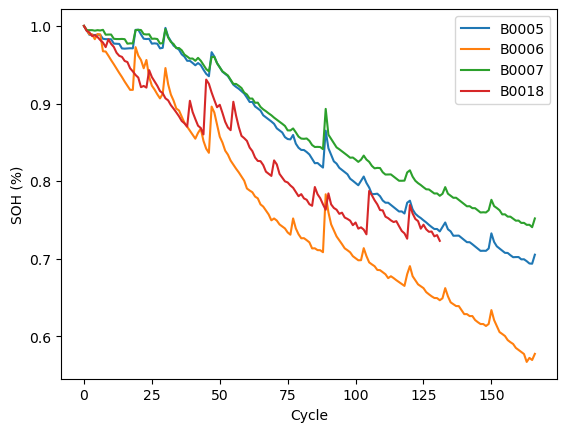

In [267]:
import pandas as pd
import numpy as np
# from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

plt.plot(dfs_B0005_soh['soh_avg'], label='B0005')
plt.plot(dfs_B0006_soh['soh_avg'], label='B0006')
plt.plot(dfs_B0007_soh['soh_avg'], label='B0007')
plt.plot(dfs_B0018_soh['soh_avg'], label='B0018')

#plt.plot(data['Cycle'], predicted_soh, label='Predicted SOH', linestyle='--')
plt.xlabel('Cycle')
plt.ylabel('SOH (%)')
plt.legend()
plt.show()


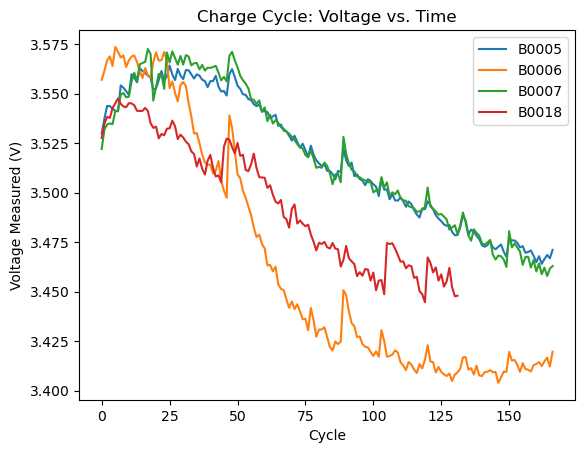

In [269]:
plt.plot(dfs_B0005_soh['Voltage_measured_avg'], label='B0005')
plt.plot(dfs_B0006_soh['Voltage_measured_avg'], label='B0006')
plt.plot(dfs_B0007_soh['Voltage_measured_avg'], label='B0007')
plt.plot(dfs_B0018_soh['Voltage_measured_avg'], label='B0018')

plt.xlabel('Cycle')
plt.ylabel('Voltage Measured (V)')
plt.title('Charge Cycle: Voltage vs. Time')
plt.legend()
plt.show()

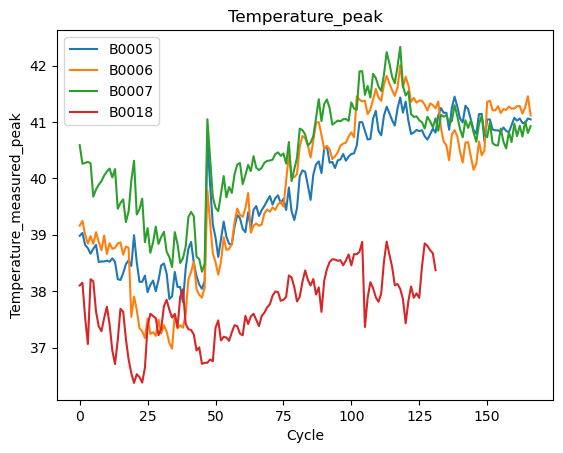

In [273]:
plt.plot(dfs_B0005_soh['Temperature_measured_peak'], label='B0005')
plt.plot(dfs_B0006_soh['Temperature_measured_peak'], label='B0006')
plt.plot(dfs_B0007_soh['Temperature_measured_peak'], label='B0007')
plt.plot(dfs_B0018_soh['Temperature_measured_peak'], label='B0018')

plt.xlabel('Cycle')
plt.ylabel('Temperature_measured_peak')
plt.title('Temperature_peak')
plt.legend()
plt.show()

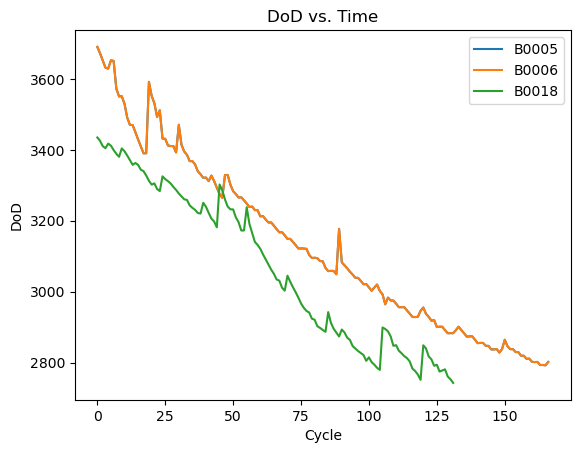

In [281]:
plt.plot(dfs_B0005_soh['Time'], label='B0005')
plt.plot(dfs_B0006_soh['Time'], label='B0006')
#plt.plot(dfs_B0007_soh['Time'], label='B0007')
plt.plot(dfs_B0018_soh['Time'], label='B0018')


plt.xlabel('Cycle')
plt.ylabel('DoD')
plt.title('DoD vs. Time')
plt.legend()
plt.show()

In [276]:
dfs_B0005_soh

,Voltage_measured,Temperature_measured,soh_avg,Voltage_measured_avg,Temperature_measured_peak,Time
0,4.191078,24.507040,1.000000,3.529829,38.982181,3690.234
1,4.189062,24.949952,0.994527,3.537320,39.033398,3672.344
2,4.187398,24.977085,0.988614,3.543737,38.818797,3651.641
3,4.188055,24.895222,0.988567,3.543666,38.762305,3631.563
4,4.188438,24.676120,0.988235,3.542343,38.665393,3629.172
...,...,...,...,...,...,...
162,4.206439,23.798733,0.699209,3.464021,41.062142,2802.031
163,4.201292,23.866336,0.696726,3.466462,40.983663,2793.390
164,4.200442,23.911337,0.693785,3.468509,40.982342,2793.390
165,4.203612,23.944537,0.693488,3.466806,41.063751,2792.485


In [282]:
dfs_B0006_soh

,Voltage_measured,Temperature_measured,soh_avg,Voltage_measured_avg,Temperature_measured_peak,Time
0,4.180205,24.445072,1.000000,3.556946,39.162987,3690.234
1,4.177195,24.839977,0.994990,3.561476,39.246203,3672.344
2,4.177877,24.948251,0.989185,3.566752,38.999202,3651.641
3,4.177790,24.957507,0.989165,3.568795,38.843628,3631.563
4,4.196360,24.355134,0.982898,3.563971,38.977989,3629.172
...,...,...,...,...,...,...
162,4.175727,23.796544,0.577101,3.412419,41.283386,2802.031
163,4.196086,23.832972,0.566893,3.414810,41.149193,2793.390
164,4.195798,23.863551,0.572092,3.416618,41.262683,2793.390
165,4.195899,23.919945,0.569339,3.412134,41.457918,2792.485
